In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams, cm, patches
from mpl_toolkits.mplot3d import Axes3D
from scipy import io, integrate
from sklearn import linear_model
import pickle
import os
import shutil
import h5py
from Equations import ksEquation
from utilities import DMD, forecastDMD

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers, Input

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from plot_keras_history import plot_history

path = '.' #os.path.dirname(os.path.realpath(__file__))
es4_dir =  os.path.join(path, 'es4')
if not os.path.exists(es4_dir):
    os.makedirs(es4_dir)


In [3]:
## GET DATA
data_path = os.path.join(path, 'data')
name = os.path.join(data_path, 'BZ.mat')

dataset_dict = {}
f = h5py.File(name)
for k, v in f.items():
    dataset_dict[k] = np.array(v)

u_full = dataset_dict['BZ_tensor']

k = u_full.shape[0]
n = u_full.shape[1]
m = u_full.shape[2]

u_temp = np.zeros((m,n,k))
for i in range(k):
    u_temp[:,:,i] = (u_full[i,:,:].T)
u_full = u_temp


In [4]:
##  DATASET DIVISION

n_t = k -300
n_p = k - 0
T = 10
t_full = np.linspace(0,T,k)
dt = t_full[1]-t_full[0]
t = np.arange(0, dt*n_t, dt)
t_pred = np.arange(0, dt*n_p, dt)

u = u_full[:,:,:n_t]
u_check = u_full[:,:,:n_p]


In [5]:
##  SVD

u_vec = u.reshape((m*n, n_t))
U, S, Vt = np.linalg.svd(u_vec, full_matrices=False)



In [6]:
##  TRUNCATION

r = 110
U_lr = U[:,:r]
S_lr = S[:r]
Vt_lr = Vt[:r,:]

u_vec_lr = U_lr @ np.diag(S_lr) @ Vt_lr
u_lr = u_vec_lr.reshape((m, n, n_t))

s_r = S[r]/np.sum(S)

print(s_r*100)


0.04199617341307625


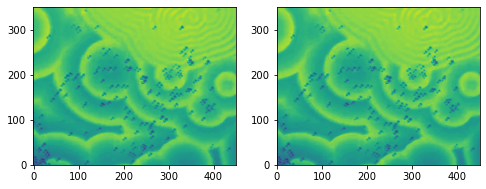

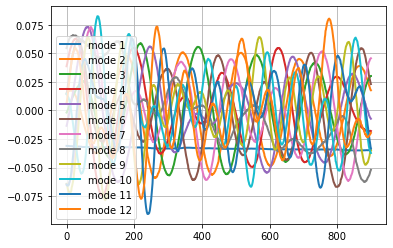

In [7]:
##   PLOT

fig_0, ax_0 = plt.subplots(1,2,figsize=plt.figaspect(0.5))
ax_0[0].imshow(u[:,:,-1], aspect='equal', interpolation='bilinear', origin='lower',\
                vmin=np.amin(u), vmax=np.amax(u))
ax_0[1].imshow(u_lr[:,:,-1], aspect='equal', interpolation='bilinear', origin='lower',\
                vmin=np.amin(u), vmax=np.amax(u))

fig_1 = plt.figure()
ax_1 = fig_1.add_subplot(111)
[ax_1.plot(Vt_lr[k,:],linewidth=2,label='mode {}'.format(k+1)) for k in range(12)]
ax_1.legend()
ax_1.grid()

plt.show()


In [8]:
##  DMD TO FULL MATRIX

X = u_vec[:,:-1]
X1 = u_vec[:,1:]

Phi, Lambda, b = DMD(X, X1, r)
u_vec_dmd, Omega = forecastDMD(Phi, Lambda, b, t_pred, 'V')
u_pred = u_vec_dmd.reshape((m, n, n_p))
u_pred = np.real(u_pred)

omega = np.diag(Omega)
omega_a = omega*dt



In [9]:
##  DMD ON THE LOW-RAN SUB-SPACE APPROXIMATION

u_tilde_lr = np.diag(S_lr) @ Vt_lr
Y = u_tilde_lr[:,:-1]
Y1 = u_tilde_lr[:,1:]

Phi_y, Lambda_y, b_y = DMD(Y, Y1, r)
u_tilde_dmd, Omega_y = forecastDMD(Phi_y, Lambda_y, b_y, t_pred)

omega_y = np.diag(Omega_y)
omega_a_y = omega_y*dt

u_pred_vec = U_lr @ u_tilde_dmd
u_pred_2 = u_pred_vec.reshape((m, n, n_p))
u_pred_2 = np.real(u_pred_2)


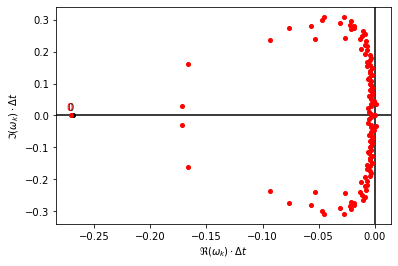

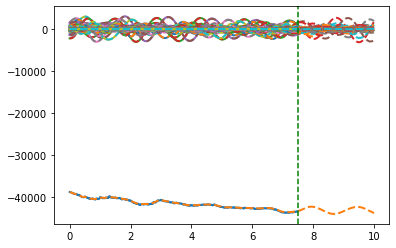

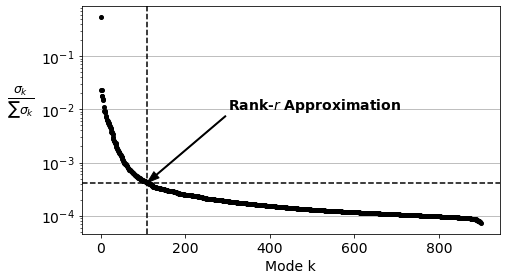

In [10]:
##  PLOTS

fig_2, ax_2 = plt.subplots()
ax_2.plot(np.real(omega_a), np.imag(omega_a), 'ko', markersize=4)
ax_2.axhline(y=0, color="black", linestyle="-")
ax_2.axvline(x=0, color="black", linestyle="-")
for i in range(len(omega_a)):
    plt.annotate(r'{}'.format(i), xy=(np.real(omega_a[i]), np.imag(omega_a[i])), \
    xytext=(-5,5), textcoords='offset points', color='k')
ax_2.set(xlabel= r'$\Re{({\omega}_k)} \cdot \Delta t$', ylabel= r'$\Im{({\omega}_k)} \cdot \Delta t$')

ax_2.plot(np.real(omega_a_y), np.imag(omega_a_y), 'ro', markersize=4)
for i in range(len(omega_a)):
    plt.annotate(r'{}'.format(i), xy=(np.real(omega_a_y[i]), np.imag(omega_a_y[i])), \
        xytext=(-5,5), textcoords='offset points', color='r')

fig_5, ax_5 = plt.subplots()
[ax_5.plot(t, u_tilde_lr[point,:], '-', t_pred, u_tilde_dmd[point,:], '--',\
linewidth=2,label='mode {}'.format(point+1)) for point in range(u_tilde_dmd.shape[0])]
ax_5.axvline(x=t[-1], color="green", linestyle="--")

fig_1, ax_1 = plt.subplots(figsize=plt.figaspect(0.56), tight_layout=True)
ax_1.semilogy(S/np.sum(S), 'k.', markersize=8)
ax_1.axhline(y=S[r]/np.sum(S), color="black", linestyle="--")
ax_1.axvline(x=r, color="black", linestyle="--")
plt.annotate(r'Rank-$r$ Approximation', xy=(r,S[r]/np.sum(S)), \
            xytext=(300,0.01),color='k', fontsize=14, fontweight='bold',\
            arrowprops=dict(facecolor='black', shrink=0.0001, width=1, headwidth=8)) #textcoords='offset points', 
ax_1.set_xlabel(xlabel='Mode k', fontsize=14)
ax_1.set_ylabel(ylabel= r'$ \frac{{\sigma}_k}{\sum {\sigma}_k} $', fontsize=18, rotation=0, labelpad=20)
ax_1.tick_params(axis='x', labelsize=14)
ax_1.tick_params(axis='y', labelsize=14)
ax_1.grid(axis='y')
fig_1.savefig('..\\report_latex\\es4_full_matrix_svd.eps', transaprent=True)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


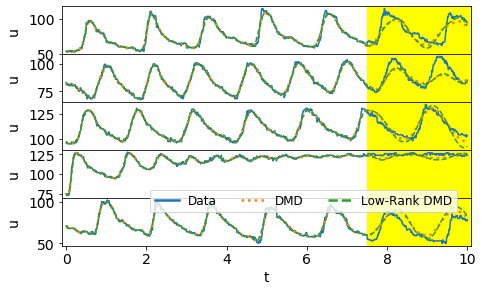

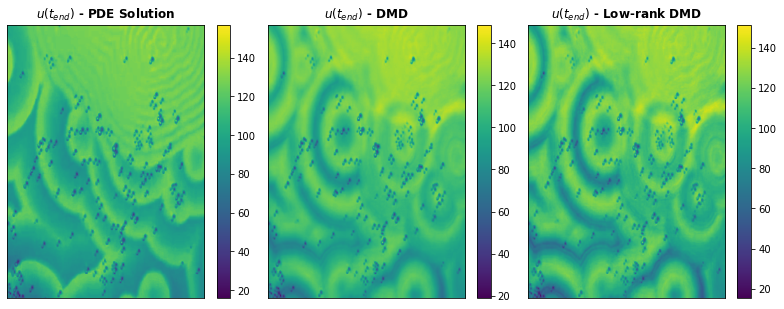

In [11]:
##  PLOTS

fig_3, ax_3 = plt.subplots(5,1,figsize=1.1*plt.figaspect(0.6), tight_layout=True, sharex='all',gridspec_kw={'hspace': 0})
l1=ax_3[0].plot(t_full, u_check[0,0,:], '-', linewidth=1.5, label='Data')
l2=ax_3[0].plot(t_full, u_pred[0,0,:], ':', linewidth=2.5, label='DMD')
l3=ax_3[0].plot(t_full, u_pred_2[0,0,:], '--', linewidth=1.5, label='Low-Rank DMD')
rect1 = patches.Rectangle((t[-1],0), 1000, 10000, color='yellow')
ax_3[0].add_patch(rect1)
ax_3[0].tick_params(axis='y', labelsize=14)
ax_3[0].annotate('Top-Left Corner', xy=(7.6,-0.6), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12) 
ax_3[0].set_ylabel(ylabel='u', fontsize=14)
ax_3[0].get_yaxis().set_label_coords(-0.1,0.5)


ax_3[1].plot(t_full, u_check[0,-1,:], '-', linewidth=1.5)
ax_3[1].plot(t_full, u_pred[0,-1,:], ':', linewidth=2.5)
ax_3[1].plot(t_full, u_pred_2[0,-1,:], '--', linewidth=1.5)
rect2 = patches.Rectangle((t[-1],0), 1000, 10000, color='yellow')
ax_3[1].add_patch(rect2)
ax_3[1].tick_params(axis='y', labelsize=14)
ax_3[1].annotate('Top-Right Corner', xy=(7.4,-0.6), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[1].set_ylabel(ylabel='u', fontsize=14)
ax_3[1].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[2].plot(t_full, u_check[-1,0,:], '-', linewidth=1.5)
ax_3[2].plot(t_full, u_pred[-1,0,:], ':', linewidth=2.5)
ax_3[2].plot(t_full, u_pred_2[-1,0,:], '--', linewidth=1.5)
rect3 = patches.Rectangle((t[-1],0), 1000, 10000, color='yellow')
ax_3[2].add_patch(rect3)
ax_3[2].tick_params(axis='y', labelsize=14)
ax_3[2].annotate('Bottom-Left Corner', xy=(7.1,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[2].set_ylabel(ylabel='u', fontsize=14)
ax_3[2].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[3].plot(t_full, u_check[-1,-1,:], '-', linewidth=1.5)
ax_3[3].plot(t_full, u_pred[-1,-1,:], ':', linewidth=2.5)
ax_3[3].plot(t_full, u_pred_2[-1,-1,:], '--', linewidth=1.5)
rect4 = patches.Rectangle((t[-1],0), 1000, 10000, color='yellow')
ax_3[3].add_patch(rect4)
ax_3[3].tick_params(axis='y', labelsize=14)
ax_3[3].annotate('Bottom-Right Corner', xy=(6.9,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)

ax_3[3].set_ylabel(ylabel='u', fontsize=14)
ax_3[3].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[4].plot(t_full, u_check[25,30,:], '-', linewidth=1.5)
ax_3[4].plot(t_full, u_pred[25,30,:], ':', linewidth=2.5)
ax_3[4].plot(t_full, u_pred_2[25,30,:], '--', linewidth=1.5)
rect5 = patches.Rectangle((t[-1],0), 1000, 10000, color='yellow')
ax_3[4].add_patch(rect5)
ax_3[4].tick_params(axis='y', labelsize=14)
ax_3[4].annotate('Random Point', xy=(7.8,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[4].set_ylabel(ylabel='u', fontsize=14)
ax_3[4].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[0].set_xlim([-0.1,10.1])
ax_3[4].set_xlabel(xlabel='t', fontsize=14)
ax_3[4].tick_params(axis='x', labelsize=14)
leg = fig_3.legend( loc=[0.31,0.28],  fontsize=12, ncol=3) #bbox_to_anchor=[0, 1],framealpha=0.7,
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=2.5)
fig_3.savefig('..\\report_latex\\es4_point_comparison.eps', transaprent=True)


fig_4, ax_4 = plt.subplots(1,3,figsize=1.1*plt.figaspect(0.4), tight_layout=True)

r = ax_4[0].imshow(u_check[:,:,-1], aspect='auto', interpolation='bilinear', origin='lower',vmin=np.amin(u_check), vmax=np.amax(u_check)) #,extent=[x[0][0],x[0][-1],y[0][0],y[0][-1]]
ax_4[0].set_title(r'$u(t_{end})$ - PDE Solution', fontweight='bold')
fig_4.colorbar(r,ax=ax_4[0])
#ax_4[0].set_xlabel(xlabel='x', fontsize=14)
#ax_4[0].set_ylabel(ylabel='y', fontsize=14, rotation =0)
ax_4[0].tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)
ax_4[0].tick_params(axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off)

m = ax_4[1].imshow(u_pred[:,:,-1], aspect='auto', interpolation='bilinear', origin='lower', vmin=np.amin(u_pred), vmax=np.amax(u_pred)) #,  extent=[x[0][0],x[0][-1],y[0][0],y[0][-1]]
ax_4[1].set_title(r'$u(t_{end})$ - DMD', fontweight='bold')
fig_4.colorbar(m,ax=ax_4[1])
#ax_4[1].set_xlabel(xlabel='x', fontsize=14)
#ax_4[1].set_ylabel(ylabel='y', fontsize=14, rotation =0)
ax_4[1].tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)
ax_4[1].tick_params(axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off)

l = ax_4[2].imshow(u_pred_2[:,:,-1], aspect='auto', interpolation='bilinear', origin='lower', vmin=np.amin(u_pred_2), vmax=np.amax(u_pred_2)) #,  extent=[x[0][0],x[0][-1],y[0][0],y[0][-1]]
ax_4[2].set_title(r'$u(t_{end})$ - Low-rank DMD', fontweight='bold')
fig_4.colorbar(l,ax=ax_4[2])
#ax_4[2].set_xlabel(xlabel='x', fontsize=14)
#ax_4[2].set_ylabel(ylabel='y', fontsize=14, rotation =0)
ax_4[2].tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)
ax_4[2].tick_params(axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off)
fig_4.savefig('..\\report_latex\\es4_surf_comparison.eps', transaprent=True)

plt.show()